In [111]:
import secrets
import pymysql
from sqlalchemy import create_engine
import sys
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

In [19]:
db_conn_str = "mysql+pymysql://{:}:{:}@{:}/{:}".format(secrets.user, secrets.password, secrets.host, secrets.db)
db_conn = create_engine(db_conn_str)

df = pd.read_sql('SELECT * FROM labelled WHERE completed = TRUE', con=db_conn)
db_conn.dispose()

In [20]:
df

,url,start,end,commentator,crowd,isHighlight,gameplay,updated_at,completed,priority,mfcc,amplitude,pitch,word,subjectivity,polarity
0,https://www.youtube.com/watch?v=02I5vVxlJhU,24,28,0,0,NaN,1,2020-02-26 22:30:23,1,10,[172.34694 59.855976 -16.23632 34.32...,-0.002607,NaN,None,None,None
1,https://www.youtube.com/watch?v=02I5vVxlJhU,40,44,0,0,NaN,1,2020-02-26 21:22:06,1,10,[ 1.8889221e+02 4.6004627e+01 -2.7908030e+00 ...,-0.002323,NaN,None,None,None
2,https://www.youtube.com/watch?v=02I5vVxlJhU,90,94,0,0,NaN,1,2020-02-27 07:19:24,1,10,[ 9.3631500e+01 9.8736382e+01 -2.8482916e+01 ...,0.000091,NaN,None,None,None
3,https://www.youtube.com/watch?v=02I5vVxlJhU,210,214,0,0,NaN,1,2020-02-27 01:53:35,1,10,[ 1.6850551e+02 6.2470104e+01 -4.0681911e+00 ...,-0.000207,NaN,None,None,None
4,https://www.youtube.com/watch?v=02I5vVxlJhU,286,290,0,0,NaN,1,2020-02-26 23:03:48,1,10,[ 1.3290944e+02 9.6197624e+01 -5.8774590e+00 ...,-0.000794,NaN,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,https://www.youtube.com/watch?v=vmb27NX36Lk,2756,2760,0,0,NaN,1,2020-02-28 03:20:35,1,10,[ 7.8034073e+01 9.1039940e+01 -2.5333509e+01 ...,0.001345,NaN,None,None,None
2126,https://www.youtube.com/watch?v=vmb27NX36Lk,2788,2792,0,0,NaN,0,2020-02-27 07:15:53,1,10,[28.74763 64.24063 4.241808 34.31897 ...,-0.011137,NaN,None,None,None
2127,https://www.youtube.com/watch?v=vmb27NX36Lk,2874,2878,1,0,NaN,0,2020-02-26 22:28:16,1,10,[ 93.075516 91.87269 -13.757497 22.92...,-0.083905,NaN,None,None,None
2128,https://www.youtube.com/watch?v=vmb27NX36Lk,2944,2948,0,0,NaN,1,2020-02-26 23:04:01,1,10,[ 1.16511185e+02 6.98217087e+01 -3.47451901e+...,0.008843,NaN,None,None,None


In [96]:
# converts mfcc string to a usable array
def mfccStrToArr(mfccStr):
    cleanedStr = mfccStr.replace('[', '').replace(']', '')
    str_arr = cleanedStr.split()
    result = list(map(lambda x: float(x), str_arr))
    return result


In [97]:
# make a new column with mfcc arrays
df['mfcc_arr'] = df.apply(lambda row: mfccStrToArr(row.mfcc), axis = 1)

,url,start,end,commentator,crowd,isHighlight,gameplay,updated_at,completed,priority,mfcc,amplitude,pitch,word,subjectivity,polarity,mfcc_arr
0,https://www.youtube.com/watch?v=02I5vVxlJhU,24,28,0,0,NaN,1,2020-02-26 22:30:23,1,10,[172.34694 59.855976 -16.23632 34.32...,-0.002607,NaN,None,None,None,"[172.34694, 59.855976, -16.23632, 34.32595, -8..."
1,https://www.youtube.com/watch?v=02I5vVxlJhU,40,44,0,0,NaN,1,2020-02-26 21:22:06,1,10,[ 1.8889221e+02 4.6004627e+01 -2.7908030e+00 ...,-0.002323,NaN,None,None,None,"[188.89221, 46.004627, -2.790803, 28.539114, 3..."
2,https://www.youtube.com/watch?v=02I5vVxlJhU,90,94,0,0,NaN,1,2020-02-27 07:19:24,1,10,[ 9.3631500e+01 9.8736382e+01 -2.8482916e+01 ...,0.000091,NaN,None,None,None,"[93.6315, 98.736382, -28.482916, 60.927795, -1..."
3,https://www.youtube.com/watch?v=02I5vVxlJhU,210,214,0,0,NaN,1,2020-02-27 01:53:35,1,10,[ 1.6850551e+02 6.2470104e+01 -4.0681911e+00 ...,-0.000207,NaN,None,None,None,"[168.50551, 62.470104, -4.0681911, 27.382914, ..."
4,https://www.youtube.com/watch?v=02I5vVxlJhU,286,290,0,0,NaN,1,2020-02-26 23:03:48,1,10,[ 1.3290944e+02 9.6197624e+01 -5.8774590e+00 ...,-0.000794,NaN,None,None,None,"[132.90944, 96.197624, -5.877459, 38.210041, 9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,https://www.youtube.com/watch?v=vmb27NX36Lk,2756,2760,0,0,NaN,1,2020-02-28 03:20:35,1,10,[ 7.8034073e+01 9.1039940e+01 -2.5333509e+01 ...,0.001345,NaN,None,None,None,"[78.034073, 91.03994, -25.333509, 28.731655, -..."
2126,https://www.youtube.com/watch?v=vmb27NX36Lk,2788,2792,0,0,NaN,0,2020-02-27 07:15:53,1,10,[28.74763 64.24063 4.241808 34.31897 ...,-0.011137,NaN,None,None,None,"[28.74763, 64.24063, 4.241808, 34.31897, 6.399..."
2127,https://www.youtube.com/watch?v=vmb27NX36Lk,2874,2878,1,0,NaN,0,2020-02-26 22:28:16,1,10,[ 93.075516 91.87269 -13.757497 22.92...,-0.083905,NaN,None,None,None,"[93.075516, 91.87269, -13.757497, 22.929829, -..."
2128,https://www.youtube.com/watch?v=vmb27NX36Lk,2944,2948,0,0,NaN,1,2020-02-26 23:04:01,1,10,[ 1.16511185e+02 6.98217087e+01 -3.47451901e+...,0.008843,NaN,None,None,None,"[116.511185, 69.8217087, -3.47451901, 29.91735..."


In [98]:
no_excite = df[df['commentator'] == 0]
slight_excite = df[df['commentator'] == 1]
very_excite = df[df['commentator'] == 2]

In [109]:
# apply tsne
featureData = df['mfcc_arr'].tolist()
tsneResult = TSNE(n_components=2).fit_transform(featureData)
tsnedf = pd.DataFrame(tsneResult, columns=['x', 'y'])


,x,y
0,-64.214493,-16.967636
1,-64.960762,-17.870043
2,-9.851329,-44.680710
3,-63.884140,-17.598783
4,-43.649364,-10.692625
...,...,...
2125,-4.855642,-29.700146
2126,18.483877,-5.330466
2127,-28.765694,2.541800
2128,-42.013004,-17.236809


In [110]:
# append tsne values to df
df['x'] = tsnedf['x'].values
df['y'] = tsnedf['y'].values

df

,url,start,end,commentator,crowd,isHighlight,gameplay,updated_at,completed,priority,mfcc,amplitude,pitch,word,subjectivity,polarity,mfcc_arr,x,y
0,https://www.youtube.com/watch?v=02I5vVxlJhU,24,28,0,0,NaN,1,2020-02-26 22:30:23,1,10,[172.34694 59.855976 -16.23632 34.32...,-0.002607,NaN,None,None,None,"[172.34694, 59.855976, -16.23632, 34.32595, -8...",-64.214493,-16.967636
1,https://www.youtube.com/watch?v=02I5vVxlJhU,40,44,0,0,NaN,1,2020-02-26 21:22:06,1,10,[ 1.8889221e+02 4.6004627e+01 -2.7908030e+00 ...,-0.002323,NaN,None,None,None,"[188.89221, 46.004627, -2.790803, 28.539114, 3...",-64.960762,-17.870043
2,https://www.youtube.com/watch?v=02I5vVxlJhU,90,94,0,0,NaN,1,2020-02-27 07:19:24,1,10,[ 9.3631500e+01 9.8736382e+01 -2.8482916e+01 ...,0.000091,NaN,None,None,None,"[93.6315, 98.736382, -28.482916, 60.927795, -1...",-9.851329,-44.680710
3,https://www.youtube.com/watch?v=02I5vVxlJhU,210,214,0,0,NaN,1,2020-02-27 01:53:35,1,10,[ 1.6850551e+02 6.2470104e+01 -4.0681911e+00 ...,-0.000207,NaN,None,None,None,"[168.50551, 62.470104, -4.0681911, 27.382914, ...",-63.884140,-17.598783
4,https://www.youtube.com/watch?v=02I5vVxlJhU,286,290,0,0,NaN,1,2020-02-26 23:03:48,1,10,[ 1.3290944e+02 9.6197624e+01 -5.8774590e+00 ...,-0.000794,NaN,None,None,None,"[132.90944, 96.197624, -5.877459, 38.210041, 9...",-43.649364,-10.692625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,https://www.youtube.com/watch?v=vmb27NX36Lk,2756,2760,0,0,NaN,1,2020-02-28 03:20:35,1,10,[ 7.8034073e+01 9.1039940e+01 -2.5333509e+01 ...,0.001345,NaN,None,None,None,"[78.034073, 91.03994, -25.333509, 28.731655, -...",-4.855642,-29.700146
2126,https://www.youtube.com/watch?v=vmb27NX36Lk,2788,2792,0,0,NaN,0,2020-02-27 07:15:53,1,10,[28.74763 64.24063 4.241808 34.31897 ...,-0.011137,NaN,None,None,None,"[28.74763, 64.24063, 4.241808, 34.31897, 6.399...",18.483877,-5.330466
2127,https://www.youtube.com/watch?v=vmb27NX36Lk,2874,2878,1,0,NaN,0,2020-02-26 22:28:16,1,10,[ 93.075516 91.87269 -13.757497 22.92...,-0.083905,NaN,None,None,None,"[93.075516, 91.87269, -13.757497, 22.929829, -...",-28.765694,2.541800
2128,https://www.youtube.com/watch?v=vmb27NX36Lk,2944,2948,0,0,NaN,1,2020-02-26 23:04:01,1,10,[ 1.16511185e+02 6.98217087e+01 -3.47451901e+...,0.008843,NaN,None,None,None,"[116.511185, 69.8217087, -3.47451901, 29.91735...",-42.013004,-17.236809


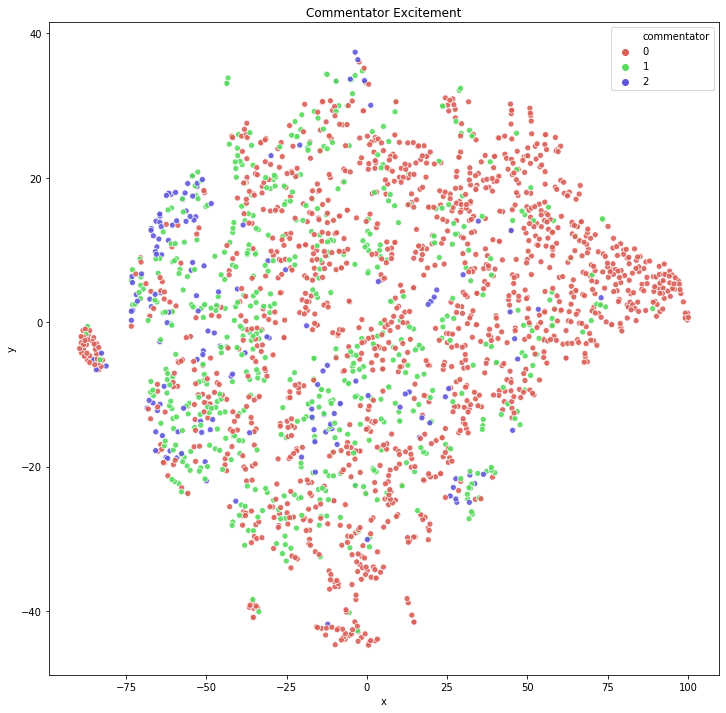

In [124]:
# plot tsne commentator excitement

plt.figure(figsize=(12,12))
plt.subplot(1,1,1)
plt.title("Commentator Excitement")
sns.scatterplot(
    x="x",
    y="y",
    hue="commentator",
    palette=sns.color_palette("hls", 3),
    data=df,
    legend="full",
    alpha=0.9
)


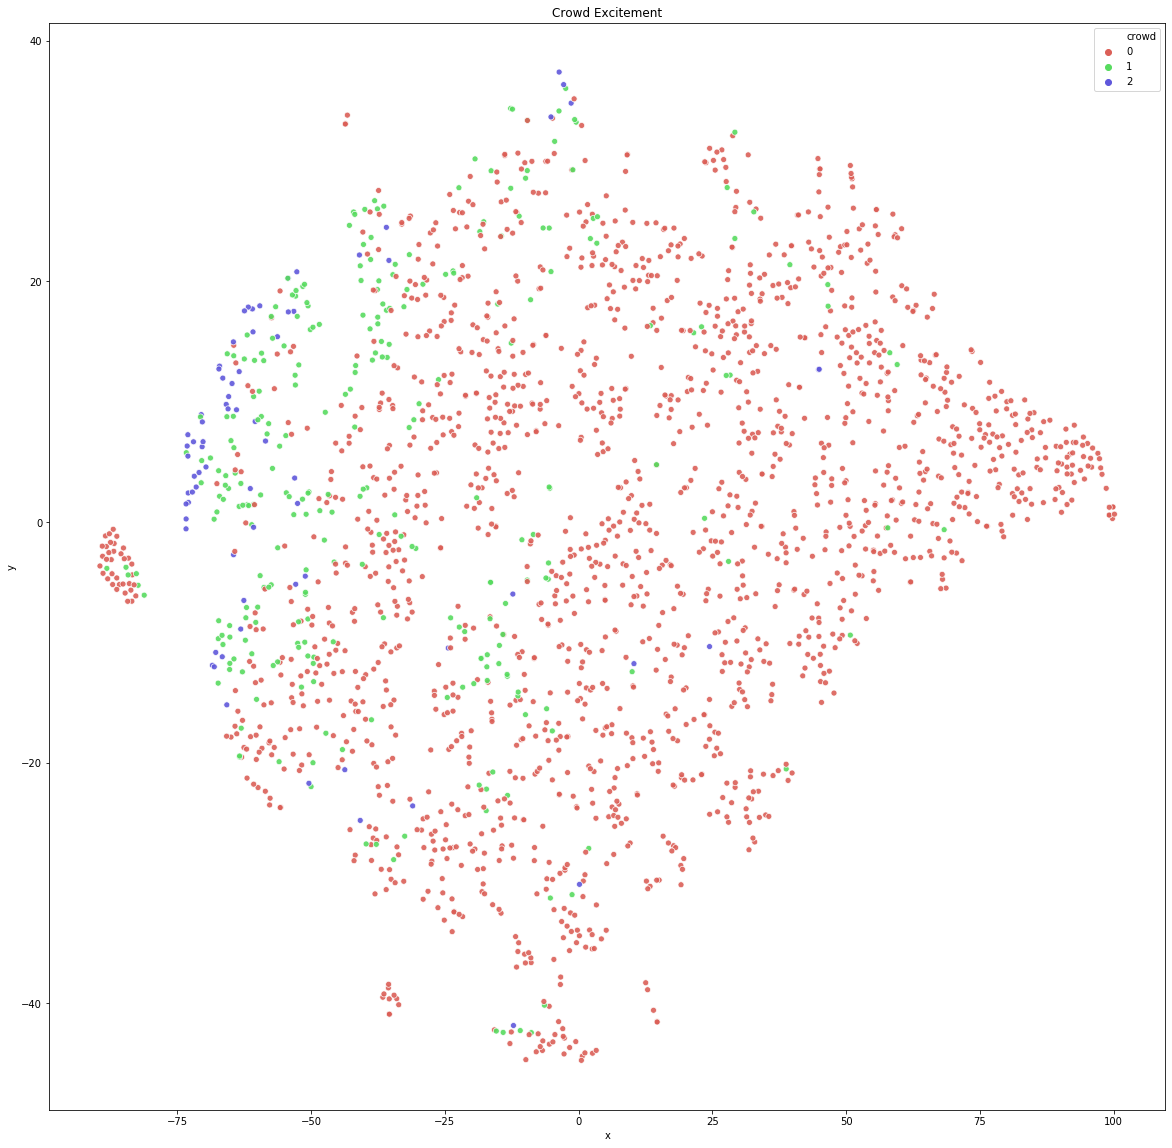

In [118]:
# plot tsne crowd excitement

plt.figure(figsize=(20,20))
plt.subplot(1,1,1)
plt.title("Crowd Excitement")
sns.scatterplot(
    x="x",
    y="y",
    hue="crowd",
    palette=sns.color_palette("hls", 3),
    data=df,
    legend="full",
    alpha=0.9
)

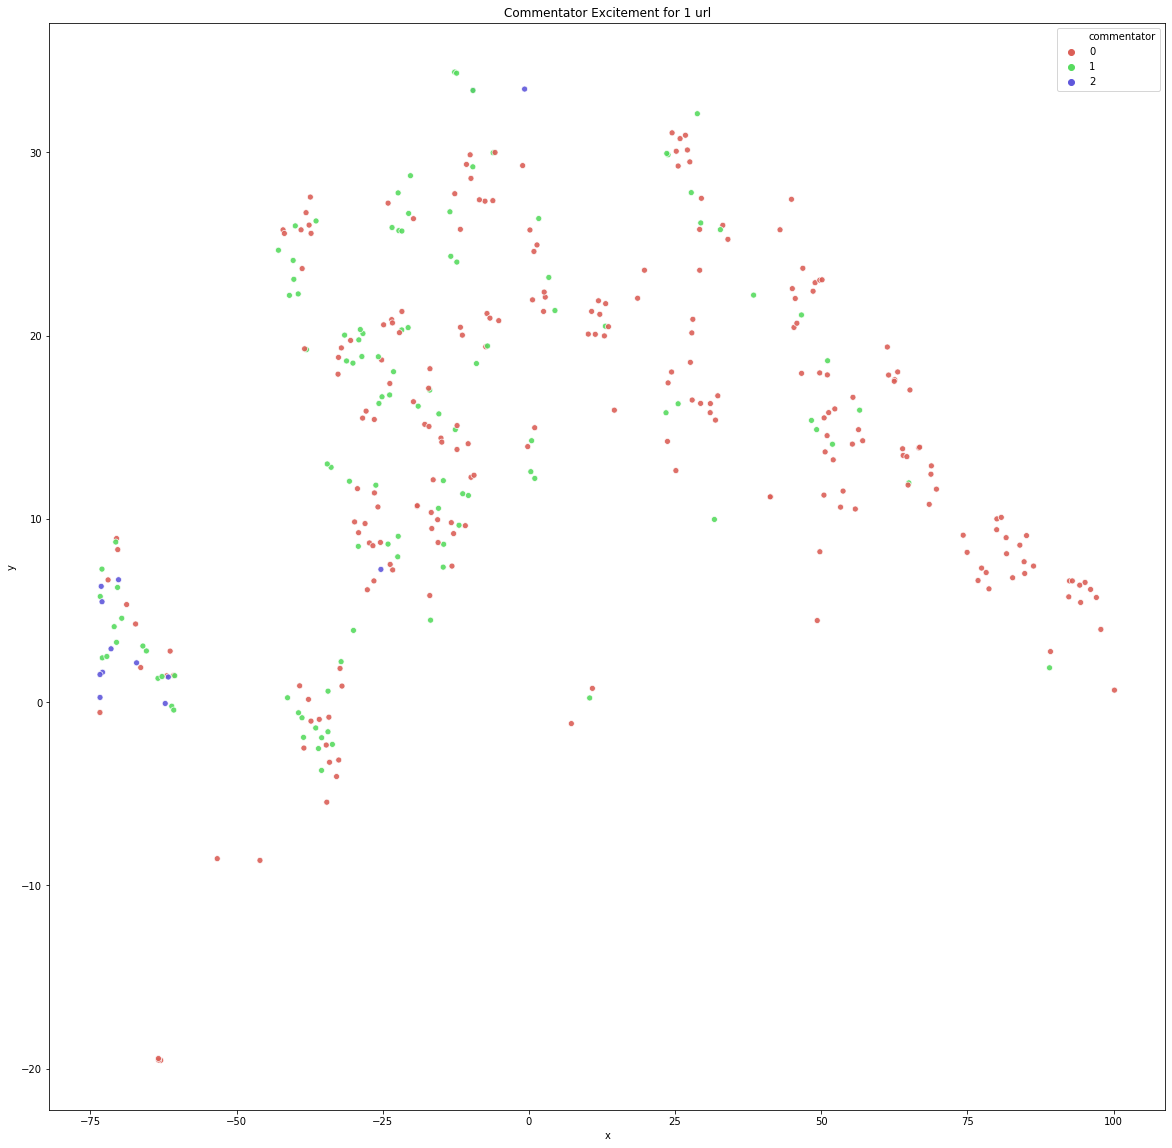

In [121]:
# Lets try plotting just 1 url https://www.youtube.com/watch?v=0UJdviXYGXQ
tempdf = df[df['url'] == 'https://www.youtube.com/watch?v=NZJPikR34bs']

plt.figure(figsize=(20,20))
plt.subplot(1,1,1)
plt.title("Commentator Excitement for 1 url")
sns.scatterplot(
    x="x",
    y="y",
    hue="commentator",
    palette=sns.color_palette("hls", 3),
    data=tempdf,
    legend="full",
    alpha=0.9
)